# Import Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta

# Open data
### Wavebuoy from OTI

In [2]:
file = "NSWENV_20250121-20250323_20m_OTInth2_WAVE_Parameters.csv"
df = pd.read_csv(file)
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True)
df = df.set_index('Time')
df.head()

,Serial,Lat,Lon,Temp,Hm0,Hsig,Hmax,Tz,Tm02,Tm01,Tp,Dp,Dm,Dp_sp,Dm_sp,Qflag,Qcode,Percent,Dof
Time,,,,,,,,,,,,,,,,,,,
2025-01-21 13:00:00,SPOT_30856C,-23.47990,152.07796,27.69,0.69,0.59,0.97,4.20,3.98,5.04,11.38,55.67,61.16,23.41,35.17,1,1,100,68
2025-01-21 13:30:00,SPOT_30856C,-23.47990,152.07803,27.70,0.73,0.62,1.05,4.21,4.12,5.26,10.24,58.47,59.96,17.35,33.96,1,1,100,68
2025-01-21 14:00:00,SPOT_30856C,-23.47983,152.07808,27.86,0.67,0.59,1.10,4.15,4.07,5.11,10.24,57.14,60.86,19.04,37.75,1,1,100,68
2025-01-21 14:30:00,SPOT_30856C,-23.47977,152.07832,28.06,0.70,0.63,1.16,4.34,4.14,5.11,9.31,58.23,59.97,21.47,33.29,1,1,100,68
2025-01-21 15:00:00,SPOT_30856C,-23.47972,152.07838,27.99,0.72,0.64,1.16,4.40,4.26,5.18,10.24,59.72,61.68,20.65,32.33,1,1,100,68


# Define study period
### Study time

In [3]:
start_period = pd.Timestamp("2025-02-01 00:00:00")
end_period   = pd.Timestamp("2025-03-31 23:59:59")

df_study = df.loc[start_period:end_period]
Hs = df_study['Hm0']   # Significant wave height

### Detect cyclone event

In [4]:
def detect_events(hs_series, thresh2=2.0, thresh3=3.0,
                  min_duration_h=72, gap_h=24):
    """
    Detect high-energy wave events:
      - Hs > thresh2 for ≥ min_duration_h  OR
      - any Hs > thresh3
    Brief dips (< gap_h hours) are ignored.
    """
    hs_series = hs_series.dropna()
    above = hs_series > thresh2
    events, in_event, start = [], False, None
    gap_count = 0

    for t, val in hs_series.items():
        if val > thresh2:
            if not in_event:
                start = t
                in_event, gap_count = True, 0
            else:
                gap_count = 0
        elif in_event:
            gap_count += 1
            if gap_count >= gap_h:
                end = t
                dur = (end - start).total_seconds() / 3600
                seg = hs_series.loc[start:end]
                if (seg.max() > thresh3) or (dur >= min_duration_h):
                    events.append((start, end))
                in_event = False

    # close if last event reaches end
    if in_event:
        end = hs_series.index[-1]
        seg = hs_series.loc[start:end]
        dur = (end - start).total_seconds() / 3600
        if (seg.max() > thresh3) or (dur >= min_duration_h):
            events.append((start, end))

    # merge events within 24 h
    merged = []
    for s, e in events:
        if not merged or (s - merged[-1][1]) > pd.Timedelta("24h"):
            merged.append([s, e])
        else:
            merged[-1][1] = e
    return merged


# ---- Run detection ----
merged_events = detect_events(df_study["Hm0"])

print("Detected High-Energy Events — One Tree Island (20 m depth)")
for i, (s, e) in enumerate(merged_events, 1):
    print(f"Event {i}: {s:%d-%b %H:%M} → {e:%d-%b %H:%M} "
          f"({(e-s).total_seconds()/86400:.1f} d)")

Detected High-Energy Events — One Tree Island (20 m depth)
Event 1: 27-Feb 08:00 → 03-Mar 03:30 (3.8 d)


In [5]:
event_records = []
for i, (s, e) in enumerate(merged_events, start=1):
    sub = df.loc[s:e]
    dur_d = (e - s).total_seconds() / 86400
    event_records.append({
        "Event_Number": i,
        "Start_Time": s,
        "End_Time": e,
        "Duration_days": round(dur_d, 2),
        "Max_Hs(m)": round(sub["Hm0"].max(), 2),
        "Mean_Hs(m)": round(sub["Hm0"].mean(), 2),
        "Max_Tp(s)": round(sub["Tp"].max(), 2),
        "Mean_Tp(s)": round(sub["Tp"].mean(), 2),
        "Mean_Tm02(s)": round(sub["Tm02"].mean(), 2),
        "Dominant_Dir(°)": round(sub["Dp"].mean(), 1)
    })

events_df = pd.DataFrame(event_records)
print("Detected Storm Events — Statistical Summary")
display(events_df)

Detected Storm Events — Statistical Summary


,Event_Number,Start_Time,End_Time,Duration_days,Max_Hs(m),Mean_Hs(m),Max_Tp(s),Mean_Tp(s),Mean_Tm02(s),Dominant_Dir(°)
0,1,2025-02-27 08:00:00,2025-03-03 03:30:00,3.81,4.64,2.38,14.63,11.09,7.36,44.1


In [6]:
# Take the longest detected event as Cyclone Alfred
events_df["Duration"] = events_df["End_Time"] - events_df["Start_Time"]
alfred_idx = events_df["Duration"].idxmax()
alfred_start = events_df.loc[alfred_idx, "Start_Time"]
alfred_end   = events_df.loc[alfred_idx, "End_Time"]

print(f"\nCyclone Alfred period ≈ {alfred_start:%d-%b %H:%M} → {alfred_end:%d-%b %H:%M}")
df_cyclone = df_study.loc[alfred_start:alfred_end]


Cyclone Alfred period ≈ 27-Feb 08:00 → 03-Mar 03:30


In [8]:
# Ensure explicit copies to prevent SettingWithCopyWarning
df_study   = df_study.copy()
df_cyclone = df_cyclone.copy()

# Physical constants
g   = 9.81    # gravitational acceleration (m s⁻²)
rho = 1025    # seawater density (kg m⁻³)

# Derived Parameters 

# 1. Peak frequency (Hz)
df_study["Fp"]   = 1 / df_study["Tp"]
df_cyclone["Fp"] = 1 / df_cyclone["Tp"]

# 2. Deep-water wavelength (L0, m)
df_study["L0"]   = (g * df_study["Tp"]**2) / (2 * np.pi)
df_cyclone["L0"] = (g * df_cyclone["Tp"]**2) / (2 * np.pi)

# 3. Group velocity (Cge, m s⁻¹)
# Deep-water approximation: Cg = g * Tp / (4π)
df_study["Cge"]   = (g * df_study["Tp"]) / (4 * np.pi)
df_cyclone["Cge"] = (g * df_cyclone["Tp"]) / (4 * np.pi)

# 4. Wave power (P_kWm, kW m⁻¹)
# Formula: P = (ρ g² Hs² Te) / (64π)
# or the simplified version below, divided by 1000 to convert to kW
df_study["P_kWm"]   = (1/16) * rho * g**2 * (df_study["Hm0"]**2) * df_study["Tm02"] / 1000
df_cyclone["P_kWm"] = (1/16) * rho * g**2 * (df_cyclone["Hm0"]**2) * df_cyclone["Tm02"] / 1000

# 5. Wave steepness (dimensionless)
# Hs / L0
df_study["Steepness"]   = df_study["Hm0"] / df_study["L0"]
df_cyclone["Steepness"] = df_cyclone["Hm0"] / df_cyclone["L0"]

# Summary Table Function 
def make_summary(df_subset):
    vars_ = ["Hm0","Hmax","Tz","Tp","Dp","Dm","Fp","Cge","P_kWm","Steepness"]
    units_map = {
        "Hm0": "m",
        "Hmax": "m",
        "Tz": "s",
        "Tp": "s",
        "Dp": "°",
        "Dm": "°",
        "Fp": "Hz",
        "Cge": "m s⁻¹",
        "P_kWm": "kW m⁻¹",
        "Steepness": "–"
    }
    out = []
    for v in vars_:
        if v in df_subset.columns:
            out.append({
                "Variable": v,
                "Units": units_map[v],
                "Mean": df_subset[v].mean(),
                "Min": df_subset[v].min(),
                "Max": df_subset[v].max(),
                "Std_Dev": df_subset[v].std()
            })
    return pd.DataFrame(out)

# Generate summaries for study and cyclone periods 
summary_study   = make_summary(df_study)
summary_cyclone = make_summary(df_cyclone)

# Merge for side-by-side comparison 
summary_combined = summary_study.merge(
    summary_cyclone, on=["Variable","Units"],
    suffixes=("_StudyPeriod","_CycloneAlfred")
)[[
    "Variable","Units",
    "Mean_StudyPeriod","Min_StudyPeriod","Max_StudyPeriod","Std_Dev_StudyPeriod",
    "Mean_CycloneAlfred","Min_CycloneAlfred","Max_CycloneAlfred","Std_Dev_CycloneAlfred"
]]

# Display and export
print("Hydrodynamic Summary — Study vs Cyclone Alfred (Feb–Mar 2025)")
display(summary_combined.round(3))

summary_combined.to_csv("OTI_summary_study_vs_alfred.csv", index=False)
print("Saved → OTI_summary_study_vs_alfred.csv")


Hydrodynamic Summary — Study vs Cyclone Alfred (Feb–Mar 2025)


,Variable,Units,Mean_StudyPeriod,Min_StudyPeriod,Max_StudyPeriod,Std_Dev_StudyPeriod,Mean_CycloneAlfred,Min_CycloneAlfred,Max_CycloneAlfred,Std_Dev_CycloneAlfred
0,Hm0,m,1.120,0.400,4.640,0.511,2.383,1.120,4.640,0.857
1,Hmax,m,1.814,0.580,12.150,0.935,3.817,1.680,12.150,1.510
2,Tz,s,5.097,3.150,10.870,1.090,7.677,5.490,10.870,1.392
3,Tp,s,8.965,3.410,34.130,2.383,11.094,9.310,14.630,1.261
4,Dp,°,55.178,1.630,355.900,36.228,44.059,12.550,68.230,11.632
5,Dm,°,55.292,0.390,359.880,37.113,46.802,20.330,71.730,11.816
6,Fp,Hz,0.119,0.029,0.293,0.031,0.091,0.068,0.107,0.010
7,Cge,m s⁻¹,6.999,2.662,26.644,1.860,8.660,7.268,11.421,0.984
8,P_kWm,kW m⁻¹,55.751,4.228,1299.687,118.815,327.200,41.452,1299.687,314.495
9,Steepness,–,0.010,0.001,0.047,0.006,0.012,0.004,0.020,0.003


Saved → OTI_summary_study_vs_alfred.csv


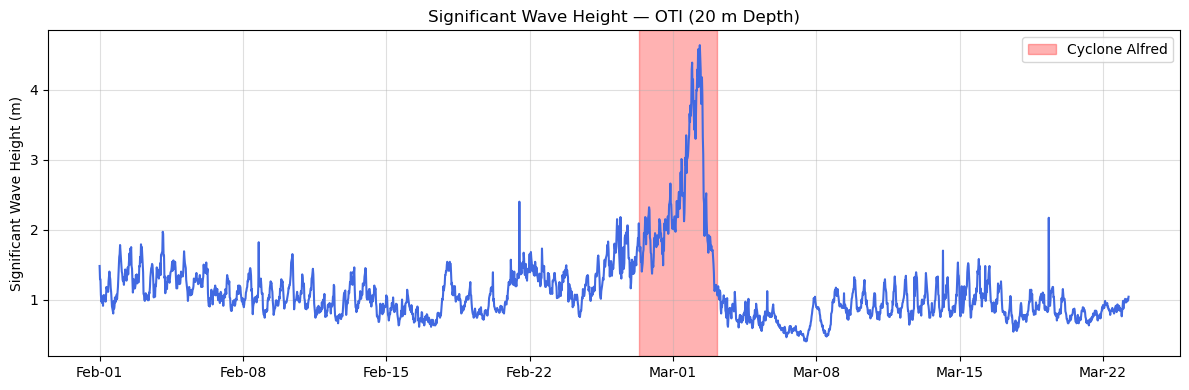

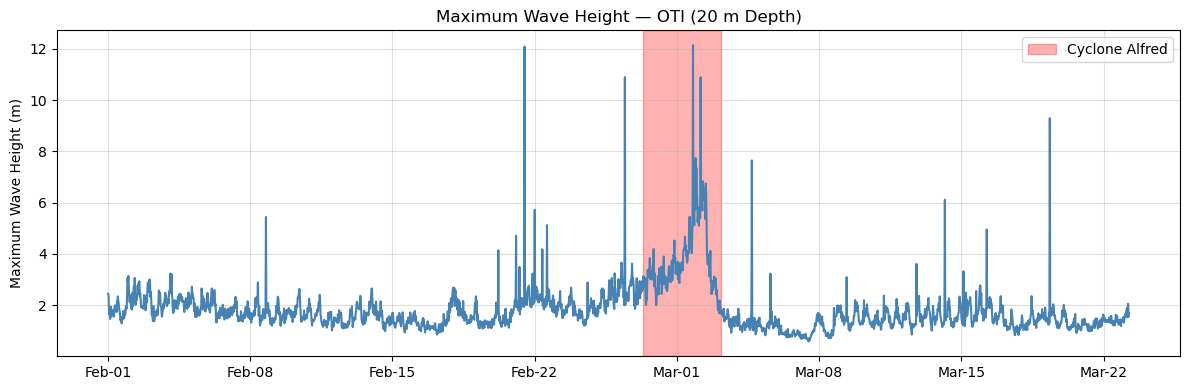

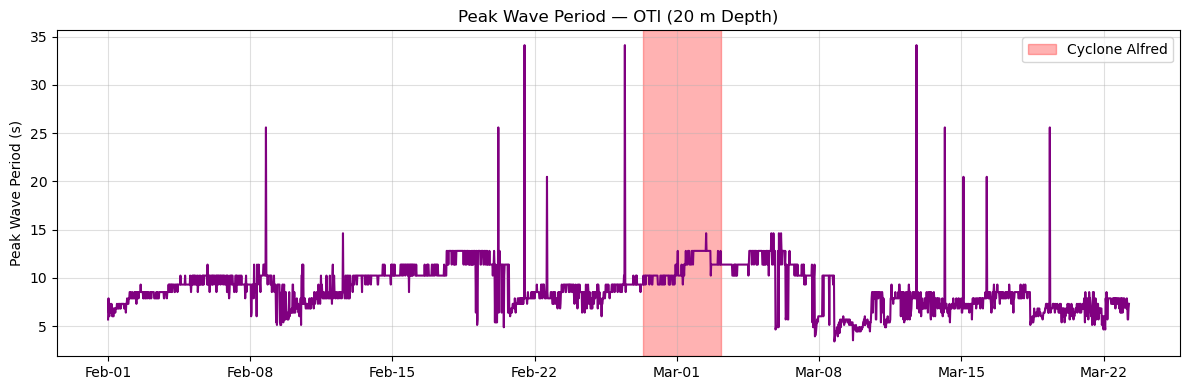

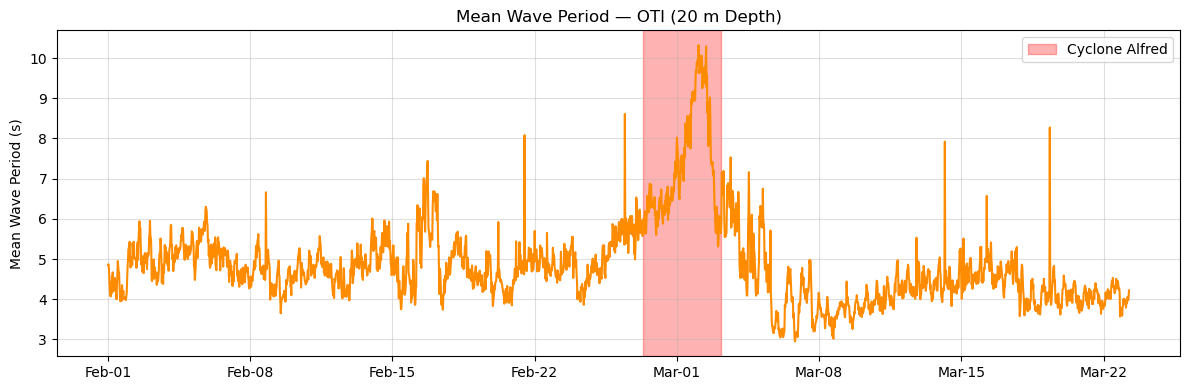

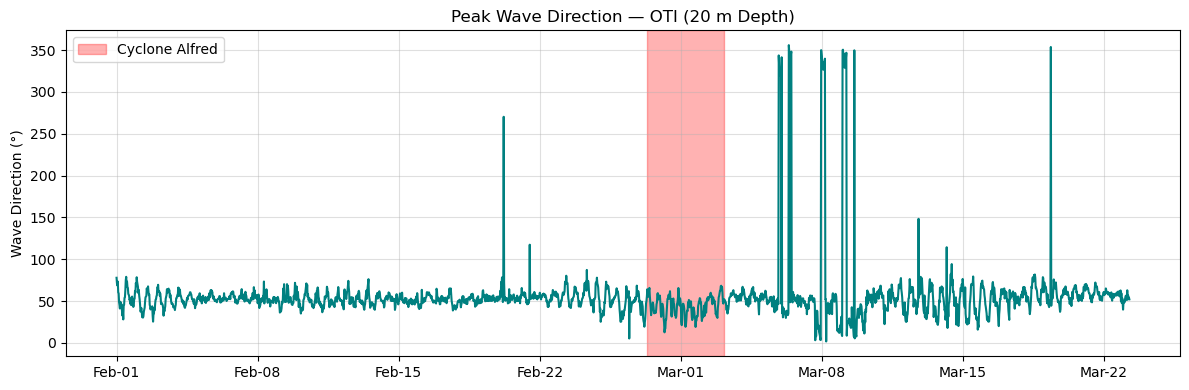

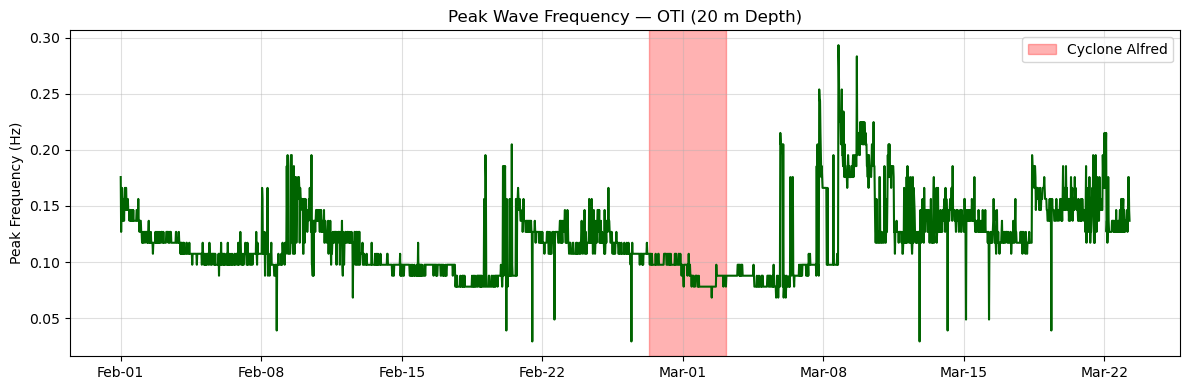

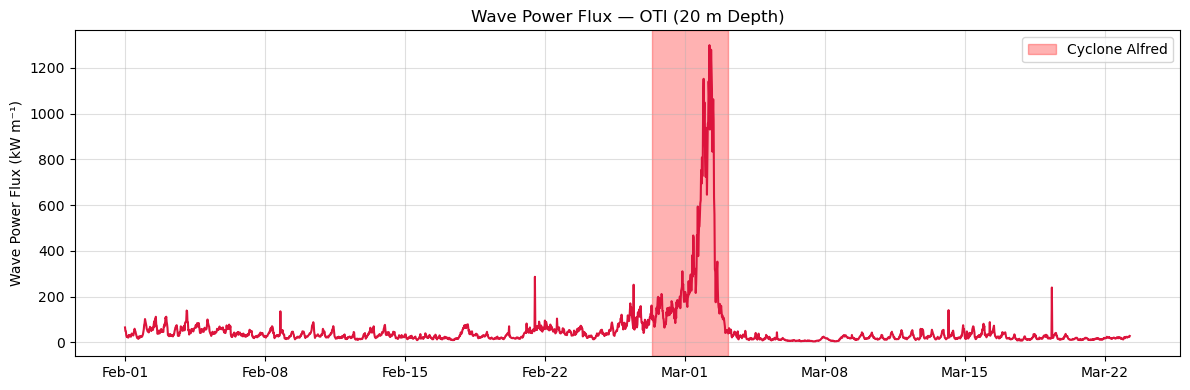

In [9]:
# Function to plot time series with Cyclone Alfred shading 
def plot_with_events(series, ylabel, title, color, filename):
    """Generic plotter for hydrodynamic time series with Cyclone Alfred shading."""
    plt.figure(figsize=(12, 4))
    plt.plot(series.index, series, color=color)
    plt.axvspan(alfred_start, alfred_end, color="red", alpha=0.3, label="Cyclone Alfred")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Hydrodynamic time series plots (Feb–Mar 2025, One Tree Island, 20 m depth) 

# Significant Wave Height
plot_with_events(df_study["Hm0"], "Significant Wave Height (m)",
                 "Significant Wave Height — OTI (20 m Depth)",
                 "royalblue", "OTI_Hm0.png")

# Maximum Wave Height
plot_with_events(df_study["Hmax"], "Maximum Wave Height (m)",
                 "Maximum Wave Height — OTI (20 m Depth)",
                 "steelblue", "OTI_Hmax.png")

# Peak Wave Period
plot_with_events(df_study["Tp"], "Peak Wave Period (s)",
                 "Peak Wave Period — OTI (20 m Depth)",
                 "purple", "OTI_Tp.png")

# Mean Wave Period
plot_with_events(df_study["Tm02"], "Mean Wave Period (s)",
                 "Mean Wave Period — OTI (20 m Depth)",
                 "darkorange", "OTI_Tm02.png")

# Peak Wave Direction
plot_with_events(df_study["Dp"], "Wave Direction (°)",
                 "Peak Wave Direction — OTI (20 m Depth)",
                 "teal", "OTI_Dp.png")

# Peak Frequency
plot_with_events(df_study["Fp"], "Peak Frequency (Hz)",
                 "Peak Wave Frequency — OTI (20 m Depth)",
                 "darkgreen", "OTI_Fp.png")

# Wave Power Flux
plot_with_events(df_study["P_kWm"], "Wave Power Flux (kW m⁻¹)",
                 "Wave Power Flux — OTI (20 m Depth)",
                 "crimson", "OTI_Power.png")

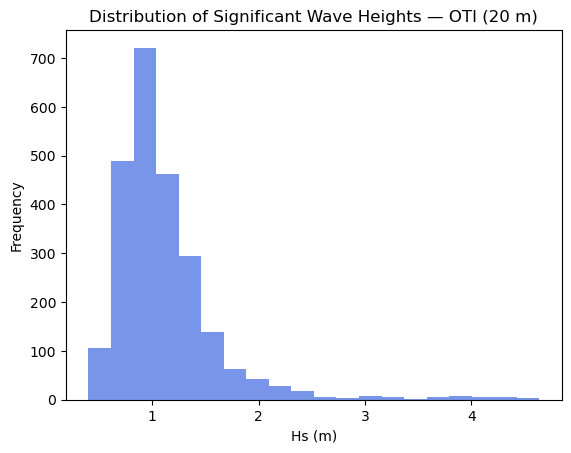

In [10]:
# Wave-height distribution
plt.hist(df_study["Hm0"], bins=20, color="royalblue", alpha=0.7)
plt.xlabel("Hs (m)")
plt.ylabel("Frequency")
plt.title("Distribution of Significant Wave Heights — OTI (20 m)")
plt.show()

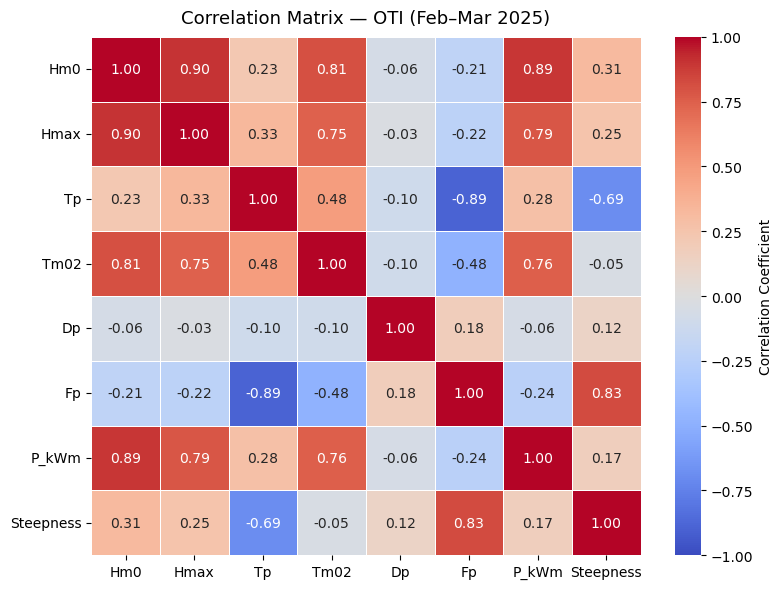

In [11]:
# Correlation Matrix for Key Hydrodynamic Parameters 

# Variables of interest
cols = ["Hm0", "Hmax", "Tp", "Tm02", "Dp", "Fp", "P_kWm", "Steepness"]

# Compute correlation matrix (automatically ignores missing values)
corr = df_study[cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1,
            linewidths=0.5, fmt=".2f", cbar_kws={"label": "Correlation Coefficient"})

plt.title("Correlation Matrix — OTI (Feb–Mar 2025)", fontsize=13, pad=10)
plt.tight_layout()
plt.savefig("OTI_Correlation_Matrix.png", dpi=300, bbox_inches="tight")
plt.show()


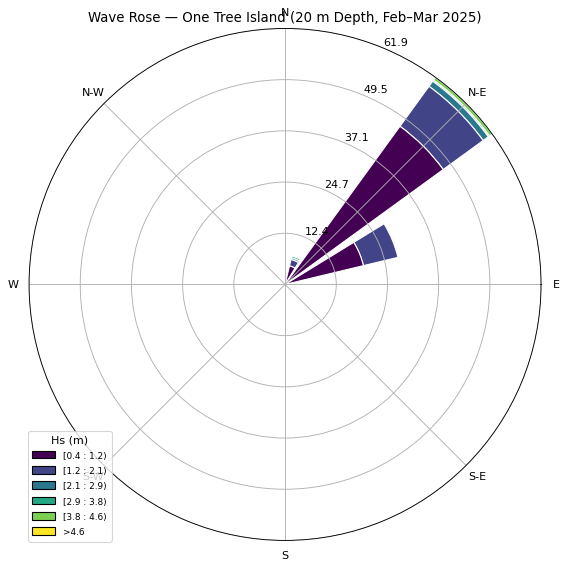

In [12]:
# Wave rose
!pip install windrose
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(df_study["Dp"], df_study["Hm0"],
       normed=True, opening=0.8, edgecolor="white")
ax.set_legend(title="Hs (m)")
plt.title("Wave Rose — One Tree Island (20 m Depth, Feb–Mar 2025)")
plt.show()